![book header](pictures/header.png)

[Table of Contents](0_Table_of_Contents.ipynb)

# Chapter 4: Module 2 - Reading KITT Sensor Data

**Contents:**
* [Distance Sensor](#distance-sensors)
* [The Microphones](#the-microphones)
* [FAQ](#faq)



In [2]:
# Import necessary libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Uncomment one of the following lines depending on your setup

# If you are using the real car, uncomment the next lines and comment the simulator lines
from serial import Serial
import sounddevice

# If you are using the simulator, uncomment the next lines and comment the real car lines
# from KITT_Simulator.serial_simulator import Serial
# from KITT_Simulator.sounddevice_simulator import sounddevice

# Note: After changing the import statement, you need to restart the kernel for changes to take effect.


KITT relies on its sensors to drive autonomously. It is equipped with:
1. Two front-mounted distance sensors.
2. Five microphones positioned around the field to record audio signals from KITT's beacon and relay them to the soundcard, after which they can be read by your PC.

This task focuses on reading data from the distance sensors to avoid obstacles and processing the microphone data from the field.

**Preparation**
- Ensure KITT is operational and properly set up.
- Reserve a time slot for testing on a field equipped with microphones and an audio card.


## Distance Sensors

KITT’s front distance sensors use ultrasonic technology. Two SRF02 modules, mounted on the left and right sides, measure the distance to obstacles. These "parking sensors" work by emitting a 40 kHz pulse and measuring the time it takes for the echo to return. This time is converted into a distance measurement.

- Each sensor requires a minimum of 66 ms between readings, as specified in the SRF02 datasheet (available on Brightspace or at `Files/Datasheets/srf02.pdf`).
- The system is configured with a 70 ms cycle time; the left and right sensors take turns recording measurements.
- These measurements are stored in a buffer on KITT's microcontroller, with each new reading overwriting the previous one. When you request the KITT status, you will obtain a copy of the current buffer values.

<img src="pictures/srf02-ultrasonic-sensor.jpg" alt="Ultrasonic Sensor" width="400" height="240">

### Step 0: Characteristics of the Distance Sensors

Using the readings on the car display, report on the following questions:

1. What is the accuracy of the distance sensors? Does this change with distance?
2. What are the minimum and maximum distances the sensors can measure?
3. What is the field of view of the distance sensors (beam angle)?

To measure this field of view, move an obstacle from left to right over a line, at about 1 m distance from the sensors, and observe when the sensors start to 'see' the object.

The field of view is important when making recordings: you should realize that the distance sensors may detect chairs, bags, etc., and then make false readings. This happens even if these objects are not straight in front of the sensors. (The field of view does depend on distance.)

**Note:** Do not copy the questions into your report, but naturally include the information in your report as part of your discussion.

### Step 1: Status Command

To ensure you can experiment at home, we have added the status command to the simulator. The simulator will accurately simulate the sensor distances, but not its behavior. Make sure to test on the real car frequently.

As you have learned in the previous module, you can ask KITT to capture a status command by writing `"S\n"` to the serial port. Then you have to read the message using `read_until`; this will generate a binary message that you need to decode. KITT always ends its message with the end-of-transmission character (0x04). The response contains three sections:
1. Audio beacon status and settings
2. PWM values for the motors
3. Sensor readings

In [45]:
### Student Version ###

serial = Serial('COM4', 115200)
serial.write(b'Sd\n')
status = serial.read_until(b"\x04")
status = status.decode('utf-8')
print(f"Car status is:\n\n{status}")

serial.close()

Car status is:

USL99
USR51



In [51]:
serial.close()

If you only need distance measurement information, you can request it separately:

```python
serial.write(b'Sd\n')
```

This returns only the left and right distance sensor values, filtering out the rest of the status report.

### Step 2: Extracting and Isolating Distance Data

Assuming you have received the full status information from KITT, you can extract and isolate the distance sensor readings (left and right) from the status report.

After sending the status command (`b'S\n'`), the response will contain a variety of information, including the distance measurements. Now write a Python function to extract the distance data from the status report.

1. **Extract the distance measurements**:

The distance values are typically embedded in the `Sensors` section of the status response. You can process the `status` output to isolate just the left (`L`) and right (`R`) distance sensor values. Write a function to extract these values.

*Hints:*

- Use `decode('utf-8')` to convert bytes to a string.
- Use `splitlines()` to separate the status message into individual lines.
- Look for the line that contains `"Dist."` to find the distance measurements.
- Use `split()` to break the line into individual words.
- Be cautious of the positions of the distance values in the list; adjust indices as necessary.

**Note:** If you use the `Sd` status command, you retrieve less info and can write a faster function! The parsing of the status string is also easier.

In [46]:
### Student Version ###

def extract_dis ():
    serial = Serial('COM4', 115200)
    serial.write(b'S\n')
    _status = serial.read_until(b'\x04')
    _status = _status.decode('utf-8')

    lines = _status.splitlines()

    # Initialize variables to hold distance values
    dist_L = None
    dist_R = None

    # Iterate over each line to find distance data
    for line in lines:
        if "Dist." in line:
            words = line.split()
            # Extract distance values based on their positions

            # Assign dist_L and dist_R accordingly
            dist_L = words[3]
            dist_R = words[5]
            break  # Exit the loop after finding the distances

    # Print the extracted distance values
    print(f"Left Distance: {dist_L}")
    print(f"Right Distance: {dist_R}")

    serial.close()

    return dist_L, dist_R

In [44]:
extract_dis()

Left Distance: 99
Right Distance: 51


('99', '51')

2. **Determine how fast you can read out (and process) your distance data** by writing a script that requests the status 100 times. You can calculate the average delay for this operation (and its standard deviation); you could also present the results in a histogram. To measure delays, you will need to keep track of time:

```python
start_time = time.time()                    # Initialize
current_time = time.time() - start_time     # Find current time since initialization
```

If you can read out the sensors faster than 70 ms (or is it 140 ms?), reason if you will obtain duplicate values from the buffer.

**Student Task:**

- Write a script that sends the status command 100 times, recording the time taken for each read.
- Store the time intervals in a list.
- After collecting the data, calculate the average delay and standard deviation.
- Plot a histogram of the delays.

In [55]:
serial.close()

The average time of a distance measurement is: 0.079 [s]
The standard deviantion of a distance measurement is: 0.035 [s]


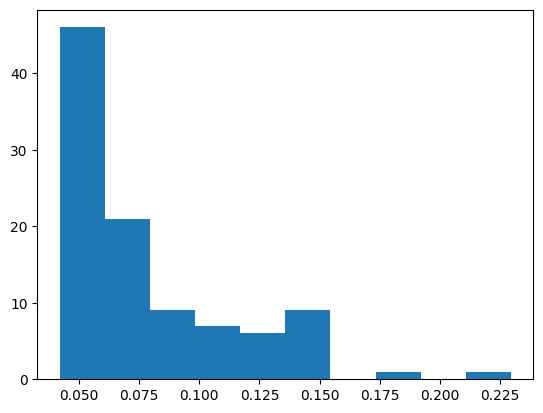

In [63]:
### Student Version ###
times = []
new_times = []
total_time = 0
summed_times = 0
serial = Serial('COM4', 115200)

for i in range(100):
    start_time = time.time()
    serial.write(b'S\n')
    _status = serial.read_until(b'\x04')
    _status = _status.decode('utf-8')
    current_time = time.time() - start_time
    times.append(current_time)

serial.close()
#print(times)

for j in range(100):
    total_time += times[j]

average = total_time / 100

for k in range(100):
    new_times.append((times[k] - average) ** 2)
    summed_times += new_times[k]

variance = summed_times / 100
standard_deviation = (variance) ** 0.5

print(f'The average time of a distance measurement is: {average:.3f} [s]')
print(f'The standard deviantion of a distance measurement is: {standard_deviation:.3f} [s]')

plt.hist(times)
plt.show()

<font color=#6698FF> As the ultrasonic sensors refresh every 70 ms taking turns, every 140 ms will give new data. So we need to measure every 140 ms to get new data and not data stored in the buffer.

### Step 3: Using Distance Values to Model the Car

Ultrasonic sensors are not just used for detecting obstacles; they play a crucial role in modeling the car's behavior during autonomous driving. To control the car effectively, we need to understand how it responds to drive and steering commands, similar to how a human driver knows how much acceleration or steering input affects the car's movement.

However, while KITT doesn’t have an accelerometer to measure acceleration directly, we can use the ultrasonic sensors to estimate how the car moves over time. By measuring the distance to a cardboard-box wall, we can derive its speed and acceleration.

#### Understanding Speed and Acceleration

- **Velocity** is the rate of change of position over time:

  $$
  v(t) = \frac{{\mathrm d} x}{{\mathrm d} t}(t) \,.
  $$

- **Acceleration** is the change in speed over time:

  $$
  a(t) = \frac{{\mathrm d} v}{{\mathrm d} t}(t) \,.
  $$

Note that $x(t)$, $v(t)$ and $a(t)$ are time varying. To implement the differentials, in practice we will subtract two subsequent samples $x(t_1)$ and $x(t_2)$. We will then have an estimate of $v(t)$ for $t = (t_1+t_2)/2$:

$$
v\left(\frac{t_1+t_2}{2}\right) \approx \frac{x(t_2) - x(t_1)}{t_2-t_1} \,.
$$

In theory, this approximation gets better for $t_2$ close to $t_1$, but at the same time the division of two small numbers will make the result very sensitive to noise, so in practice there is a trade-off.

#### Plotting KITT's Motion Towards a Wall

To understand how KITT moves, make recordings of the distance sensor values as KITT drives towards a wall. Do this for multiple motor commands, and store them in a `.csv` file. (You can use the `Files/Recordings` folder to organize your data). You can then later import the data into Python. Next to the sensor values, you should also store the time stamp of each sample.

You will see KITT speed up, and then reach a constant speed. To do this experiment, please let KITT drive towards the supplied cardboard wall. **Turn off KITT's motors once the distance is less than 40 cm to ensure KITT does not crash into the wall.**  Note that you may have to discard the first few readings as they may be inaccurate.

*Hints:*

- Choose an appropriate motor speed value for `motor_speed_value`.
- Ensure that you stop the car if it gets too close to the wall to prevent collisions.
- Use `time.time()` to keep track of elapsed time.
- Store the data in a list with the format `[current_time, dist_L, dist_R]`.
- Write the data to a CSV file for later analysis.
- Also document the motor speed setting (e.g. use this as part of your file name).

In [65]:
serial.close()

In [74]:
### Student Version ###
from pathlib import Path

# TODO: Open the serial connection to KITT, set the motor speed
serial = Serial('COM4', 115200)
serial.write(b'D150\n')
serial.write(b'M160\n')

# Initialize a list to store recorded data
data = []

# Record data for a specified duration (e.g., 10 seconds)
recording_duration = 10  # in seconds
start_time = time.time()

while time.time() - start_time < recording_duration:
    # Send the status command to get the distance readings
    serial.write(b'S\n')
    
    # Read the status response
    status = serial.read_until(b'\x04').decode('utf-8')
    
    # TODO: Extract the distance values from the status response

    dist_L = None
    dist_R = None

    lines = status.splitlines()

    for line in lines:
        if "Dist." in line:
            words = line.split()
            # Extract distance values based on their positions

            # Assign dist_L and dist_R accordingly
            dist_L = int(words[3])
            dist_R = int(words[5])
            break

    # TODO: Record current time and distances

    current_time = time.time() - start_time
    data.append([current_time, dist_L, dist_R])
    
    # Check if KITT is too close to the wall and stop if necessary
    if dist_L < 100 or dist_R < 100:
        serial.write(b'M145\n')
        time.sleep(0.5)
        serial.write(b'M150\n')  # Stop the car
        print("Stopping KITT to avoid collision.")
        break  # Exit the loop
        # Note: you can also add a small loop here and still read the stopping data
    
    time.sleep(0.1)  # Wait before the next reading

# Close the serial connection
serial.close()

# TODO: Write the recorded data to a CSV file
filepath = Path('kitt_wall_data_160.csv')
df = pd.DataFrame(data,columns = ["Time","Distance_L","Distance_R"])
df.to_csv(filepath,index=False)
# Recommeded file output: Files/Recordings/kitt_distance_data_{speed}.csv

Stopping KITT to avoid collision.


#### Processing the Recorded Data

Read your `.csv` data into Python (see template script below), and plot the distance values over time to visualize KITT's motion. Use a single plot with separate colors for the L and R sensors. You should notice a 'staircase' shape! Explain this in your report.

Next, to derive velocity, first merge the L and R sensor data into a single position estimate: remove the duplicate values (keep only the first value of a duplicate reading), then merge the remaining values into a single (time, position) array. Plot the result in your distance plot to see if you did this correctly.

After that, estimate the velocity of KITT as function of time. Obviously, you will use $ v(t) = \Delta x / \Delta t \ $, but what time $t$ do you associate with each of these estimates?

Make a plot of the resulting velocity estimates over time.

*Hints:*

- When merging the L and R distance measurements, don't simply average them. Read the above paragraph again.
- Be aware that the sensors alternate readings every 70 ms, leading to a 'staircase' effect.
- To calculate velocity, use the differences in distance and time (`diff()` function).
- Since KITT is moving towards the wall, the distance decreases; yet, the estimated velocity should be positive when moving forward.
- For the time associated with each velocity estimate, use the midpoint between consecutive time stamps.
- Remove any NaN values resulting from the `diff()` operation.

In [ ]:
### Student Version ###

motor_speed_value = 160  # Use the same motor speed as during recording

# Load the recorded data from the CSV file
csv_filename = f'Files/Recordings/kitt_distance_data_{motor_speed_value}.csv'
data = pd.read_csv(csv_filename)

# Consider discarding the first few readings (inaccurate readings)

# TODO: Remove duplicate time stamps and merge L and R data
# Create a new DataFrame to hold your processed data
merged_data = []

# Iterate over the data
for index, row in data.iterrows():
    # Extract time and distances
    time_stamp = row['Time']
    dist_L = row['Distance_L']
    dist_R = row['Distance_R']
    
    # TODO: Decide which distance to use or how to merge them
    distance = 

    merged_data.append([time_stamp, distance])

# Convert merged data to DataFrame
merged_df = pd.DataFrame(merged_data, columns=['Time', 'Distance'])

# TODO: calculate velocity (change in distance over change in time)
merged_df['Velocity'] = 

# Note: Use a negative sign because distance to the wall decreases as KITT moves forward

# Calculate the time corresponding to each velocity estimate
# It's common to use the midpoint of the time intervals
merged_df['Velocity_Time'] = merged_df['Time'] - merged_df['Time'].diff() / 2

# Plotting Distance
plt.figure()
plt.plot(merged_df['Time'], merged_df['Distance'], label='Distance to Wall')
plt.xlabel('Time (s)')
plt.ylabel('Distance (cm)')
plt.title('Distance to Wall Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Velocity
plt.figure()
plt.plot(merged_df['Velocity_Time'], merged_df['Velocity'], label='Velocity (cm/s)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Velocity of KITT Over Time')
plt.grid(True)
plt.legend()
plt.show()

**Tips to Consider:**

**Continuous Measurement** involves data that can be taken at any point in time, with no gaps. For example, a car’s speedometer provides a continuous record of the car’s speed.

**Discrete Measurement**, on the other hand, collects data at specific intervals. For instance, KITT’s ultrasonic sensors take distance readings every 70 ms. In between these measurements, we don’t know the exact position of the car. Discrete data can still be useful, but it may miss details about rapid changes in speed or acceleration that occur between measurements. In order to interpret it correctly, you may need to filter or interpolate the data.

The following shows the difference between continuous and discrete data:

In [ ]:
# Define time for continuous measurement (smooth, no gaps)
time_continuous = np.linspace(0, 10, 1000)  # Time from 0 to 10 seconds, 1000 data points
# Define time for discrete measurement (specific intervals)
time_discrete = np.linspace(0, 10, 20)  # Time from 0 to 10 seconds, 20 data points
# Simulate continuous speed (sinusoidal speed pattern for illustration)
speed_continuous = 10 * np.sin(0.5 * np.pi * time_continuous)  # Continuous speed
# Simulate discrete speed (sampled at specific intervals)
speed_discrete = 10 * np.sin(0.5 * np.pi * time_discrete)  # Discrete speed
# Plotting both continuous and discrete measurements
plt.figure(figsize=(7, 4))
plt.plot(time_continuous, speed_continuous, label="Continuous Measurement", color="blue")
plt.scatter(time_discrete, speed_discrete, label="Discrete Measurement", color="red", zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Continuous vs Discrete Measurement of Speed')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Implementing the Distance Sensor Reading in Your KITT Class

In the previous module, you have created a class for KITT. Add a method to read the distance sensors to your `KITT` class in your 'Student Code' files. You can use the code you have written in the previous steps to do this. Make sure to test your code. It is advisable to store all the old distance data in a list inside the `KITT` class. This will be convenient during the final challenge, where the route planning might need old measurements to determine the position of objects.

**Student Task:**

- Add a method `read_distance_sensors()` to your `KITT` class.
- The method should send the status command to KITT and extract the distance measurements.
- Store the readings along with timestamps in an internal list or data structure.

### Step 6: Mid-term Assessment 2.1 and Report

After you finish this assignment, and ultimately in week 4, showcase the functionality of your script to your assigned TA. After you pass this assessment, you are ready to document your results in your midterm report. For this Module, you would include a chapter that covers the above tasks (using independently-readable text, i.e., don’t refer to “Step 1”).

Include plots; for each plot, it should be clear how the plot was made (i.e., the corresponding experimental setup), and you have to describe what is seen in the plot before you discuss results and derive conclusions. Review the guidelines in Chapter 7 for more information. Include the corresponding code in an appendix.

Remember to document your code, using comments to define input/output variables of functions and to explain the logic and any modifications made. Your completed script will be crucial for the upcoming challenges, contributing to the overall autonomous driving system.

## The Microphones

The field is equipped with four microphones at its corners, and a fifth microphone positioned at a higher level between two of the edge microphones. These microphones, together with the beacon mounted on KITT, will be used to locate KITT within the field (more details in Chapter 5).

<img src="pictures/axisdef.png" alt="Microphones Axis Defenition" width="400" height="240">

To use the microphone array, you must ensure that the correct sound card driver is installed. The sound card used in this project is the **Scarlett 18i20 3rd Gen**. Below are instructions on how to configure Sounddevice and the necessary drivers on different platforms.

### Simulator
For the Sounddevice package another simulator has been made. The simulator will return a realistic audio recording, and change the recordings according to the location of the car. But, it contains only 1 recording, so it will not appear as random as the real car. It also does not adjust to your particular beacon settings. Make sure to test on the real car frequently. Use it in combination with the serial simulator to change locations and test like you would on the real car.

### Important: Lab rules for the microphone array

When working with the microphone array, please follow these rules to ensure smooth operations and avoid disrupting other groups:

1. **Do not rearrange the microphone connectors**. The setup is shared between multiple groups, and changing the connections may lead to incorrect results for other teams.
2. **Do not touch the volume settings**. If the volume needs adjustment, contact a TA for assistance.
3. **Handle the equipment carefully**. The microphone array and associated hardware are sensitive, and mishandling could cause damage.
4. **Start and stop on time**. The lab is shared, and other groups have scheduled time slots. Be respectful of their time.

Test time is limited. But by using the simulator and preparing a plan of what you want to test during each scheduled slot, there should be enough time to complete the tasks. 

### Step 1: Initializing the microphone array

Before using the microphone array, it must first be initialized. As part of the initialization process, you will need to specify the sampling frequency (`Fs`) that will be used to record the audio. The sampling frequency will vary based on the test field you are working with, and it will be **48 kHz** or **44.1 kHz**.

A typical laptop or PC may have multiple audio devices (e.g., built-in microphones, Bluetooth headsets, external sound cards). To ensure that the correct device is used, you can list all available audio devices using Sounddevice and select the appropriate one. Use the following code snippet to list all audio devices recognized by Sounddevice and find the index of the Scarlett 18i20 or any other relevant device:

In [ ]:
sounddevice_handle = sounddevice()
for i in range(sounddevice_handle.get_device_count()):
    device_info = sounddevice_handle.get_device_info_by_index(i)
    print(i, device_info['name'])


Once you have identified the index of the microphone array device from the list, you can initialize it by specifying the device index (`device_index`) and the desired sampling frequency (`Fs`).

Here’s how you can open the audio stream using Sounddevice:

In [ ]:
# Initialize sounddevice again
sounddevice_handle = sounddevice()

# Specify the device index and sampling frequency
device_index = 1 # Replace with the index of your microphone device
Fs = 44100  # or 48000, depending on the field setup. Try to use 48000 when making your own recordings.

# Open the audio stream with 5 channels, 16-bit audio format (paInt16), and the specified sample rate
stream = sounddevice_handle.open(input_device_index=device_index,
                             channels=5,
                             format='float32',
                             rate=Fs,
                             input=True)

### Step 2: Recording audio data

To make a recording with the microphone array, you must specify the **length of the recording** as the number of **audio frames** to capture. Each audio frame consists of samples from all 5 microphones. Given that we are using 16-bit audio (2 bytes per sample), each frame will contain **10 bytes** (5 microphones × 2 bytes per sample).

Thus, recording **N frames** will produce **10N bytes** of data. Note: The simulator returns a fixed length recording at 44.1 kHz. The real car will return a recording of the length you specify.

The following command records `N` frames from the microphone array and stores the result as a numpy array:

In [ ]:
Fs = 44100  # Sampling frequency
N = 2*Fs  # 2 seconds of audio data
samples,_ = stream.read(N)

At this point, the microphone data is **interleaved**. This means that the first value (`data[0]`) corresponds to the first sample of microphone 0, the second value (`data[1]`) corresponds to the first sample of microphone 1, and so on. For example, `data[5]` contains the second sample of microphone 0, and the pattern continues. To visualize the interleaving of the data, refer to the table below:

| data[0] | data[1] | data[2] | data[3] | data[4] | data[5] | data[6] | data[7] | ... |
|---------|---------|---------|---------|---------|---------|---------|---------|-----|
| mic 0   | mic 1   | mic 2   | mic 3   | mic 4   | mic 0   | mic 1   | mic 2   | ... |
| frame 0 | frame 0 | frame 0 | frame 0 | frame 0 | frame 1 | frame 1 | frame 1 | ... |

#### Deinterleaving the data

To work with the data from each microphone independently, the **interleaved data** must be split into separate streams for each microphone. This process is called **deinterleaving**.

Write a function to deinterleave the audio data and store the samples from each microphone in a separate numpy array:

In [ ]:
### Student Version ###

# TODO: Reshape the data into a matrix with 5 columns (one for each microphone)

### Plotting the audio data

Once you've extracted the audio data for each microphone, you can plot it using Python. **Matplotlib** is a commonly used module for creating plots. Plot the audio data from each microphone to visualize the sound captured by the microphone array:

In [ ]:
### Student Version ###

# TODO: Plot the data for each microphone

### Step 3: Testing the microphone array
Below are some experiments you can perform to test the microphone array, and develop the code.

**Part 1: Clapping**: With the real microphones connected, have your teammate clap in front of each microphone in turn. Record the audio data and plot the results. Is the order of the microphones what you expected? How does the sound intensity change as you move from one microphone to another?

**Part 2: Beacon detection**: Turn on KITT's beacon and record the results. Can you identify where KITT is located just by observing the shift in the recordings? Change the beacons parameters and see how it affects the recordings.

**Part 3: Ideal OOK signal**: Compare the waveform of the recording to an ideal OOK of your code.  What can you see, and what do you infer from this? Are some beacon signals better than others? How can you find a good beacon signal? (This point is revisited in Module 3.)

**Part 4: Reference recording**: Make some recordings of the beacon at different locations. These recordings will be useful to your teammates working on the localization algorithm. Similarly, make a recording of a single pulse from the beacon close to one of the microphones. Cut out the pulse and save it separately.

**Part 5: KITT class**: Add a method to read the microphones to your KITT class in 'Student Code' files. The method should make a stream, turn on the beacon, start the recording, stop the recording, and turn off the beacon. You can choose to return the recording as a result, or store it internally inside the KITT class. Make sure to test your code.

*Bonus Tasks - Optional*

- See if you can automate selecting the correct sounddevice device index. The correct device index changes from one computer to another and can sometimes even change on the same computer after a reboot. So, it is worth your time to make a program that can automatically select the right device index.
- Implement start-up sanity checks: some process which you can run after you arrive at the test field, so that you can quickly check the microphone connections and audio levels.




### Mid-term assessment 2.2 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your
assigned TA. After you pass this assessment, you are ready to document your results in your midterm
report.

For this Module, you would include a chapter that covers the above tasks (using independently-readable
text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made
(i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before
you discuss results and derive any conclusions. Be sure to answer the questions posed along with the
plots (using independently-readable text).

Include the corresponding code in an Appendix. Remember to document your code, using comments
to define input/output variables of functions and to explain the logic and any modifications made. Your
completed script will be crucial for the upcoming challenges, contributing to the overall autonomous
driving system.

This concludes the mid-term assignments related to communication with KITT. After the mid-term, you
must integrate this module with the localization module created by your colleagues. Take into account
that integrating is often harder than originally anticipated, e.g. your code has to run in parallel, and you
have to worry about timing aspects. Hopefully, using the KITT class will provide you with a sturdy and
flexible framework to continue your work towards the final challenge


## FAQ

**What is the beam angle ?**

The beam angle of a sensor refers to how wide the sensor's detection area is. It determines how much space the sensor can cover when it sends out signals (like sound or light) to detect objects.

To determine the beam angle of ultrasonic sensors mounted in front of the car, you have multiple options: 

1. **Check the sensor datasheet**: The easiest way or at least a way to get some idea to determine the beam angle is to refer to the manufacturer's datasheet for your specific ultrasonic sensor. The datasheet will typically provide the beam angle, often around 15 to 30 degrees for common ultrasonic sensors. But keep in mind that is for a single sensor and not the current set up! Also, the 'reach' of the sensor is angle dependent: straight ahead, it can see several meters, but at an angle, perhaps just half a meter.  

2. **Experimental Determination for KITT**:
   - **Measure detection width**: Place a flat object (like a wall) at a fixed distance in front of the sensor (e.g., 1 meter).
   - **Move the object**: Move the object left and right to determine the points where the sensor stops detecting the object.
   - **Calculate the angle**: Measure the distance between these two points (detection width) and the distance from the sensor to the object. You may use the following formula:

   
     $$
     \text{Beam Angle} = 2 \times \arctan\left(\frac{\text{Detection Width}/2}{\text{Distance to Object}}\right)$$
     
   - This calculation will give you the beam angle in degrees.


**I see random numbers from sensors for large distances. Is my sensor damaged ?**

During experiments, you may occasionally receive random or unexpected data from the sensors. This can occur not only when the sensors are operating outside their effective range but also at times when they are within range. Several factors (consider what they might be?) can cause ultrasonic sensors to produce inaccurate readings. Additionally, since there are two sensors—one on the left and one on the right—they might produce different, completly different readings.


**Are the ultrasonic sensor measurements for the left and the right side done at exactly the same time ?**

If you closely observe the blinking of the small LEDs on the ultrasonic board on the car, you might notice that they turn on and off alternatingly. This indicates a slight time difference in the sensor measurements. This delay is also noticeable and can be measured using a moving car. (The reason to operate the two sensors alternatingly is that otherwise they might interfere on each other.)